# Visualize Air Pollution in Bangkok

# Background

Air pollution is a pollution threat in many Asian countries. Being informed about the current outdoor air quality helps you protect yourself. Recently, Thai people become more concern about local air pollution due to the high level of pollution in Bangkok in winter of 2019. Air polution is reported as air quality index (AQI). The high AQI mean bad air pollution. The major pollutant was the small size particle pollution (PM2.5). Still there are a lot of misconceptions and debates about the causes of the pollution and degree of hazard of particles. 

This notebook tried a way to answer answer some of the questions about air pollution through data visualization. Moreover, it includes how to generate these vizs are generated so that the same method can be applied to your local air quality measurement. I was inspired by the work from  a Facebook post by [Data-addict](https://scontent-sjc3-1.xx.fbcdn.net/v/t1.0-9/34398114_426447444494150_7618108699801812992_n.png?_nc_cat=108&_nc_ht=scontent-sjc3-1.xx&oh=0ac2b42de652b994d8f1994ecb835418&oe=5CF14B7F)

I wrote the blog post about this result on [Medium.com](https://towardsdatascience.com/identifying-the-sources-of-winter-air-pollution-in-bangkok-part-i-d4392ea608dc).

In [3]:
import sys
sys.path.append(r'C:\Users\Benny\fastai\old')
from pathlib import Path
from fastai.imports import *
import seaborn as sns

import statsmodels.api as sm
import datetime 
import matplotlib.dates as mdates
import matplotlib as mpl
from matplotlib.gridspec import GridSpec

from statsmodels.sandbox.regression.predstd import wls_prediction_std
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar

# Import Data

## Import google trend data

This is the data about search frquency of the keywords 'AQI' and 'pm2.5'. 
1. Convert the date columns to date-time data type
2. Convert the trend to integer. 
3. Quick plot to check the data.

In [57]:
# load google trend data on the search keyword 'aqi' and 'pm2.5'
trend_aqi = pd.read_csv('data/google_trend_aqi.csv', infer_datetime_format=True,
                       skiprows=3, names= ['date','aqi_trend'])
trend_pm25 = pd.read_csv('data/google_trend_pm25.csv', infer_datetime_format=True,
                       skiprows=3, names= ['date','pm25_trend'])

# combine into one df
trend = trend_aqi.merge(trend_pm25, on=['date'], how ='outer')

In [58]:
trend.head()

,date,aqi_trend,pm25_trend
0,2014-02-23,0,<1
1,2014-03-02,<1,<1
2,2014-03-09,1,0
3,2014-03-16,1,<1
4,2014-03-23,1,<1


In [60]:
# change the date column to datetime type
trend['date'] =  pd.to_datetime(trend['date'],yearfirst=True)

In [61]:
# replace <1 string to 0 
trend['aqi_trend'] = trend['aqi_trend'].str.replace('<1','0')
trend['pm25_trend'] = trend['pm25_trend'].str.replace('<1','0')
# convert google trend data to integer
trend[['aqi_trend', 'pm25_trend']] = trend[[
    'aqi_trend', 'pm25_trend']].astype(np.int32)

In [86]:
# save the data for later use
trend.to_csv('data/google_trend_all.csv',index=False)

In [55]:
# load google trend data
trend = pd.read_csv('data/google_trend_all.csv',infer_datetime_format=True)
trend['date'] = pd.to_datetime(trend['date'])

As mentioned above, more people are unaware of the air pollution problem in the past, but there are an increased interests. How do I know that ? There are surge of Google search for the words 'PM2.5' and 'AQI' in Thailand around 2019. 

Text(0.5, 1.0, 'Google Search Frequency in Thailand')

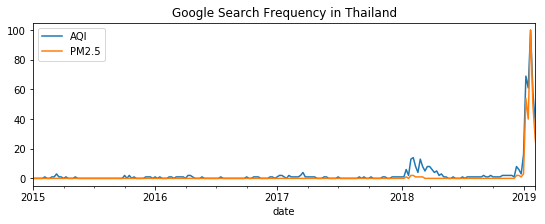

In [261]:
trend.plot('date', ['aqi_trend', 'pm25_trend'], kind='line',
           label=['AQI','PM2.5'], xlim=['2015-01-01', '2019-02-07'],
          figsize=(9,3))
plt.title('Google Search Frequency in Thailand')

## Load PM 2.5 data

How AQI are calculated? That depends on the law in different countries. They mostly divided into four pollutants source: ground level ozone(O3), particle pollution (PM2.5 and PM10), toxic gas (NO2, CO, SO2). The table below shows different pollutants from various stations in Thailand on February 2, 2019. There are level of CO, NO2, O3, SO2, PM10 and PM2.5. Most level are normal except, high level of PM2.5 in some region. 

PM2.5 are particle of size smaller than 2.5 micron. PM2.5 concentation higher than 35 ug/m3 is considered moderate and unhealthy for sensitive group with AQI 100 and above 55.4 ug/m3 is consider unhealthy with AQI 150. Since AQI is calculated from the highest level of pollutant aveage over 24 hours([1](https://airnow.gov/index.cfm?action=aqi_brochure.index)), we focus this notebook on PM 2.5 data. 

What cause high air pollution in Bangkok last winter? The sources of PM2.5 particle can be car engine, power plants, and agricultural waste burning. There are number of theories: still wind, old diesel cars, near by power plants, and agricultural burning from other provinces. Let's try to answer some of these questions through visualization. 

![AQI report Thailand](data/aqi_2019_02_19.png)

The government official website only provides a month historical data. I use the PM 2.5 from Berkeley Earth [website](http://berkeleyearth.lbl.gov/air-quality/maps/cities/Thailand/). Detail about how to use Python to scrap this data can be found in this [notebook](https://github.com/worasom/aqi_thailand/blob/master/webscraping-PM25.ipynb). Also if you are interested in scrapping the data from the government website directly, you may find this [notebook](https://github.com/worasom/aqi_thailand/blob/master/webscraping-AQI.ipynb) useful.

The data from Berkeley Earth is a .txt file with header. The header contain geometrical location, city name and region name. City and region actually refer to sub-province and province, accordingly.

In [255]:
# inspecting the top of the files 
with open('data/Bangkok.txt','r') as f:
    for i in range(12):
        print(f.readline())

% Country: Thailand

% City: Bangkok

% City (ASCII): Bangkok

% Region: Bangkok

% Region (ASCII): Bangkok

% Population: 5104476

% Latitude: 13.754

% Longitude: 100.5014

% Time Zone: Asia/Bangkok

% Year, Month, Day, UTC Hour, PM2.5, PM10_mask, Retrospective

2016	3	3	8	62.9	1.00	0

2016	3	3	9	62.9	1.00	0



The PM10_mask, and Retrospective columns are uniform.

In [116]:
#load bangkok data
pm25 = pd.read_csv('data/Bangkok.txt', sep='\t', 
                   header=None, skiprows=10)

In [118]:
#assemble datetime column 
pm25['Time'] = pd.to_datetime({'year': pm25[0], 'month': pm25[1], 'day':pm25[2],'hour': pm25[3]})
#convert to Bangkok time zone and remove the time zone information
pm25['Time'] = pm25['Time'].dt.tz_localize('UTC').dt.tz_convert('Asia/Bangkok')
pm25['Time'] = pm25['Time'].dt.tz_localize(None)
# drop Year, month, day, UTC hours, PM10_mask columns
pm25=pm25.drop([0,1,2,3,5,6],axis=1)
pm25.columns = ['PM2.5', 'Time']

In [123]:
# save the fie
pm25[['Time','PM2.5']].to_csv('data/bkk_pm25.csv',index=False)

# Explore Data and Feature Engineers

Data preparation steps such as adding the year, day of month, day of week and the average particle levels. 

For easy visualization, plot the 24 hours average instead of the direct reading.

In [124]:
# load the data
bkk = pd.read_csv('data/bkk_pm25.csv')
bkk['Time'] = pd.to_datetime(bkk['Time'])
bkk.head()

,Time,PM2.5
0,2016-03-03 15:00:00,62.9
1,2016-03-03 16:00:00,62.9
2,2016-03-03 17:00:00,55.5
3,2016-03-03 18:00:00,55.5
4,2016-03-03 19:00:00,47.9


In [600]:
bkk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23667 entries, 0 to 23666
Data columns (total 2 columns):
Time     23667 non-null datetime64[ns]
PM2.5    23667 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 369.9 KB


In [125]:
# rolling average over 24 hours window
bkk['PM2.5avg'] = bkk['PM2.5'].rolling(24).mean()
bkk = bkk.dropna()

In [126]:
pm25 = bkk.set_index('Time')

In [228]:
# add datetime feature
pm25['Year'] = pm25.index.year
pm25['Month'] = pm25.index.strftime('%B')
pm25['DayofMonth'] = pm25.index.day
pm25['DayofWeek'] = pm25.index.strftime('%A')
pm25['TimeofDay'] = pm25.index.time
pm25['is_weekend'] = 'weekday'
pm25.loc[pm25['DayofWeek'].isin(['Saturday','Sunday']),'is_weekend'] ='weekend'
pm25['month-year'] = pm25.index.strftime('%b-%Y')

# put the data into level and color based on the PM2.5 reading for easy visualization
pm25['level'] = pd.cut(pm25['PM2.5avg'],bins = [0, 35.5, 55.5, 150.4], 
                       labels=['satisfactory', 'moderate','unhealthy'],
                      include_lowest=True, right=False)
pm25['color'] = pd.cut(pm25['PM2.5avg'],bins = [0, 35.5, 55.5, 150.4], 
                       labels=['green', 'orange','red'])



In [229]:
pm25.head()

,PM2.5,PM2.5avg,Year,Month,DayofMonth,DayofWeek,TimeofDay,level,color,season,is_weekend
Time,,,,,,,,,,,
2016-03-04 15:00:00,34.2,43.520833,2016,March,4,Friday,15:00:00,moderate,orange,NaN,weekday
2016-03-04 16:00:00,35.0,42.358333,2016,March,4,Friday,16:00:00,moderate,orange,NaN,weekday
2016-03-04 17:00:00,30.0,40.987500,2016,March,4,Friday,17:00:00,moderate,orange,NaN,weekday
2016-03-04 18:00:00,25.6,39.741667,2016,March,4,Friday,18:00:00,moderate,orange,NaN,weekday
2016-03-04 19:00:00,32.1,38.766667,2016,March,4,Friday,19:00:00,moderate,orange,NaN,weekday


In [230]:
# save the data
pm25.to_csv('data/bkk_pm25_proc.csv')

#  Data Visualization

Try to answer questions about air pollution in Bangkok through visualization 
* Is the problem getting worse?
* Which months have the highest level of PM2.5 in Bangkok? 
* What time has the highest pollution?
* Is the pollution lower during the holiday?

In [277]:
#load the data and change time columne to datetime index
pm25 = pd.read_csv('data/bkk_pm25_proc.csv')
pm25['Time'] = pd.to_datetime(pm25['Time'])
pm25 = pm25.set_index('Time')
pm25.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24130 entries, 2016-03-04 15:00:00 to 2019-03-07 04:00:00
Data columns (total 11 columns):
PM2.5         24130 non-null float64
PM2.5avg      24130 non-null float64
Year          24130 non-null int64
Month         24130 non-null object
DayofMonth    24130 non-null int64
DayofWeek     24130 non-null object
TimeofDay     24130 non-null object
level         24130 non-null object
color         24130 non-null object
season        15649 non-null object
is_weekend    24130 non-null object
dtypes: float64(2), int64(2), object(7)
memory usage: 2.2+ MB


In [278]:
pm25.head()

,PM2.5,PM2.5avg,Year,Month,DayofMonth,DayofWeek,TimeofDay,level,color,season,is_weekend
Time,,,,,,,,,,,
2016-03-04 15:00:00,34.2,43.520833,2016,March,4,Friday,15:00:00,moderate,orange,NaN,weekday
2016-03-04 16:00:00,35.0,42.358333,2016,March,4,Friday,16:00:00,moderate,orange,NaN,weekday
2016-03-04 17:00:00,30.0,40.987500,2016,March,4,Friday,17:00:00,moderate,orange,NaN,weekday
2016-03-04 18:00:00,25.6,39.741667,2016,March,4,Friday,18:00:00,moderate,orange,NaN,weekday
2016-03-04 19:00:00,32.1,38.766667,2016,March,4,Friday,19:00:00,moderate,orange,NaN,weekday


Plot the particle pollution vs time.

In [289]:
# check if the data contains all levels
pm25['level'].unique().astype(str)

array(['moderate', 'satisfactory', 'unhealthy'], dtype='<U12')

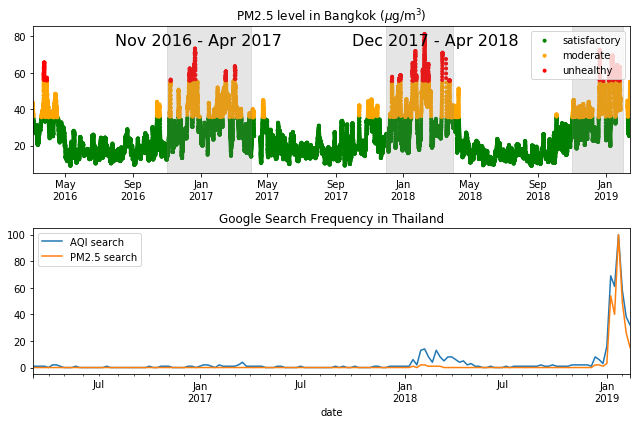

In [65]:
fig = plt.figure(figsize=(9, 6))
ax1 = fig.add_subplot(211)

# make legend and plot each level at a time 
# Each level has to be plotted separtely to generate proper legend
for legend in ['satisfactory', 'moderate', 'unhealthy']:
    temp = pm25[pm25['level']==legend]
    # plot the data for each pollution level
    ax1.scatter(temp.index, temp['PM2.5avg'], 
                c=temp['color'], marker='.', label=legend)

plt.legend(loc='upper right')
plt.title("PM2.5 level in Bangkok ($\mu$g/m$^3$)")

# add vertical spand adnotation 
ax1.axvspan('2016-11','2017-04', color='gray', alpha=0.2)
plt.text('2017-01', 75, r'Nov 2016 - Apr 2017 ',
         {'color': 'k', 'fontsize': 16, 'ha': 'center'})

# add vertical spand adnotation
ax1.axvspan('2017-12','2018-04', color='gray', alpha=0.2)
plt.text('2017-10', 75, r'Dec 2017 - Apr 2018 ',
         {'color': 'k', 'fontsize': 16, 'ha': 'left'})
# add vertical spand adnotation
ax1.axvspan('2018-11','2019-02', color='gray', alpha=0.2)
# format the top plot xaxis tick style
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%b\n%Y"))
plt.xlim(pm25.index.min(), pm25.index.max())

# plot google trend data
ax2 = fig.add_subplot(212)
trend.plot('date', ['aqi_trend', 'pm25_trend'], kind='line',
           label=['AQI search', 'PM2.5 search'], ax=ax2)
plt.title('Google Search Frequency in Thailand')
# set the xaxis range to be the same 
plt.xlim(pm25.index.min(), pm25.index.max())
plt.tight_layout()

The air pollution seem to be seasonal, with surge around winter seasion (Dec - Jan). In fact, the winter pollution exists since 2017, but public awareness has just increased recently.

Is the problem getting worse every year? I am going to decided based on two graphs: the average pollution level and the number of day with moderate and unhealthy pollution level.

First, I try grouping the data by year, then I try grouping by season instead because the problem start around November to March next year. I use the later approach. 

### Group data by year

In [23]:
num_days = pd.DataFrame()
# number of day per year with particle lever higher than limit (AQI 150)
num_days['unhealthy'] = pm25[pm25['PM2.5avg'] > 55.4].resample('d').mean().groupby('Year').count()['DayofMonth']

# number of day per year with particle lever higher than limit (AQI 100)
num_days['moderate'] = pm25[pm25['PM2.5avg'] > 35.4].resample('d').mean().groupby('Year').count()['DayofMonth'] - num_days['unhealthy']
num_days.index = num_days.index.astype(int)

Text(0.5, 1.0, 'numbers of bad air days')

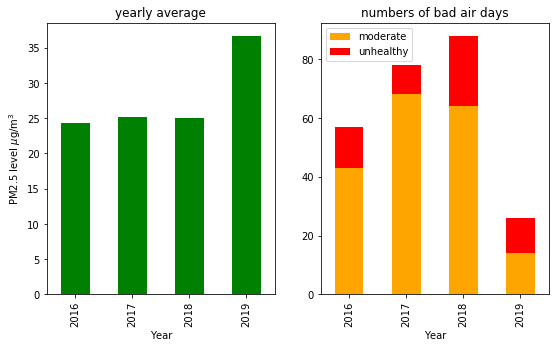

In [24]:
fig, ax = plt.subplots(1,2,figsize=(9,5))

# find yearly PM2.5 average
yearavg = pm25.groupby('Year').mean()['PM2.5avg']
# plot the yearly average 
yearavg.plot(kind='bar', color ='green',ax=ax[0])
ax[0].set_ylabel('PM2.5 level $\mu$g/m$^3$')
ax[0].set_title('yearly average')

# plot number of bad air day for each year
num_days[['moderate','unhealthy']].plot(kind='bar', stacked=True, color = ['orange','red'], ax=ax[1])
ax[1].set_title('numbers of bad air days')

In [71]:
print(yearavg)

Year
2016    24.376378
2017    25.117491
2018    25.037562
2019    43.118296
Name: PM2.5avg, dtype: float64


The average for 2019 is high because we only have the winter data, which has high pollution.This set of data does not have data in Jan-Feb of 2016, and 2015, which explain why the number of day is lower in 2016. The year 2018 has 25 days with very high AQI (from the Jan-Feb and Dec). Without more data, it's hard to judge if the situation is getting worse. 

To summarize, the yearly average is not increasing, but the number of days with high AQI seem to be higher. Another way to see trend for time series data is to look at the rate of change, which is shown below. 

(array([736420., 736511., 736603., 736695., 736785., 736876., 736968., 737060.]),
 <a list of 8 Text xticklabel objects>)

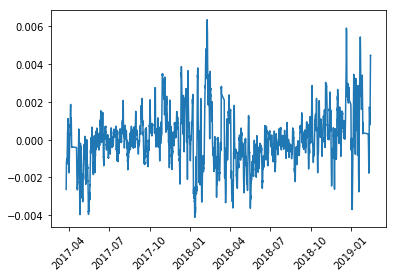

In [588]:
plt.plot(pm25['PM2.5avg'].diff().rolling(24*30*12).mean())
plt.xticks(rotation=45)

The rate of change is around zero except at the very end. This confirm that the problem is about the same every year. 

### Group data by season

Next, I will try another way to present the yearly trend. Since the pollution is seasonal around, winter, it's best to group the data by season rather than year.

In [409]:
# select the data and resample by day
dayavg = pm25['PM2.5'].resample('d').mean().to_frame()
# create season, which start in Sep and end in May. 
# I select some month before and after winter starts to get some basedline
dayavg['season'] = 'other\nseasons'
dayavg.loc['2016-09':'2017-05','season'] = 'winter\n2016-2017'
dayavg.loc['2017-09':'2018-05','season'] = 'winter\n2017-2018'
dayavg.loc['2018-09':'2019-05','season'] = 'winter\n2018-2019'

dayavg['level'] = pd.cut(dayavg['PM2.5'],bins = [0, 35.5, 55.5, 150.4], 
                       labels=['satisfactory', 'moderate','unhealthy'],
                      include_lowest=True, right=False)
dayavg.tail()

,PM2.5,season,level
Time,,,
2019-03-03,30.445833,winter\n2018-2019,satisfactory
2019-03-04,25.304167,winter\n2018-2019,satisfactory
2019-03-05,28.466667,winter\n2018-2019,satisfactory
2019-03-06,31.725000,winter\n2018-2019,satisfactory
2019-03-07,23.740000,winter\n2018-2019,satisfactory


In [411]:
# check of the separation work well
dayavg['season'].unique()

array(['other\nseasons', 'winter\n2016-2017', 'winter\n2017-2018', 'winter\n2018-2019'], dtype=object)

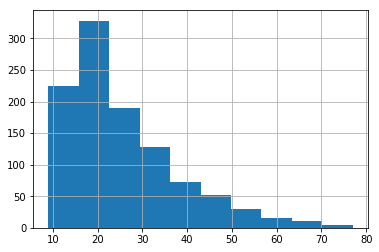

In [126]:
#check the distribution 
dayavg['PM2.5'].hist()

In [178]:
# calculate seasonal average and number of days with high pollutions
numdays = pd.DataFrame()
numdays = dayavg[['season','level','PM2.5']].groupby(['season','level'],
                                                    as_index=False).count()
# count the number of days with bad air
numdays = numdays[numdays['level']!='satisfactory']
numdays = numdays.dropna()
# pivot into two columns based on level of pollution
numdays = pd.pivot_table(numdays,index='season',columns='level')
numdays.columns = ['moderate','unhealthy']
numdays.head()

,moderate,unhealthy
season,,
winter\n2016-2017,51,9
winter\n2017-2018,57,13
winter\n2018-2019,32,11


The number in 2019 is still low due to lack of data from the future. To estimate this missing data, I use the average during march 08 - may 31 and add to the data. 

In [211]:
temp=pd.concat([dayavg.loc['2016-03-08':'2016-05-31', 'level'].value_counts(),
 dayavg.loc['2017-03-08':'2017-05-31', 'level'].value_counts(),
          dayavg.loc['2018-03-08':'2018-05-31', 'level'].value_counts()],axis=1)

temp = temp.mean(axis=1).astype(int)
temp

satisfactory    66
moderate        12
unhealthy        1
dtype: int32

In [215]:
numdays.iloc[-1,0] = numdays.iloc[-1,0]+ temp['moderate']
numdays.iloc[-1,1] +=  temp['unhealthy']

In [412]:
# calculate the seasonal average 
yearavg = dayavg[['season','PM2.5']].groupby('season', as_index=False).agg({'PM2.5':[np.mean,np.std]})
yearavg['color'] = pd.cut(yearavg['PM2.5','mean'],bins = [0, 35.5, 55.5, 150.4], 
                       labels=['green', 'orange','red'], include_lowest=True, right=False).astype(str)
yearavg.columns = [a+b for a,b in yearavg.columns]

yearavg

,season,PM2.5mean,PM2.5std,color
0,other\nseasons,19.112784,8.002606,green
1,winter\n2016-2017,28.765613,12.395808,green
2,winter\n2017-2018,28.570890,13.535275,green
3,winter\n2018-2019,29.876587,12.793924,green


In [400]:
[a+b for a,b in yearavg.columns]

['season', 'PM2.5mean', 'PM2.5std', 'color']

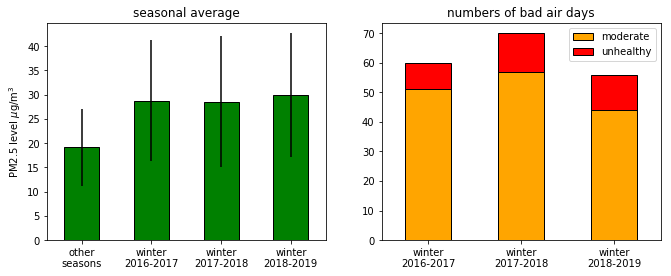

In [414]:
fig, ax = plt.subplots(1,2,figsize=(11,4))

#plot seasonal average
yearavg.plot(x='season', y='PM2.5mean',yerr='PM2.5std', kind='bar', 
             edgecolor='black', color='green',ax=ax[0], legend=None)
ax[0].set_ylabel('PM2.5 level $\mu$g/m$^3$')
ax[0].set_title('seasonal average')
ax[0].tick_params(rotation=0)
ax[0].xaxis.label.set_visible(False)

#plot number of bad air days using a stackbar plot
numdays.plot(kind='bar',stacked=True, color = ['orange','red'], edgecolor='black', ax=ax[1])
ax[1].set_title('numbers of bad air days')
ax[1].tick_params(rotation=0)
ax[1].xaxis.label.set_visible(False)


In [218]:
numdays

,moderate,unhealthy
season,,
winter\n2016-2017,51,9
winter\n2017-2018,57,13
winter\n2018-2019,44,12


## What is the best time to visit bangkok ?

Bangkok is a tourist city, which month should you avoid going to Bangkok. If you are Bangkokians what is the best time to go for a jog? Is the air pollution better during the holiday when everyone is away?

I am going to perform analysis for 2017 and 2018. First, separate a table for 2017 and 2018, and then create a daily average for each date of month.

In [34]:
pm25.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24130 entries, 2016-03-04 15:00:00 to 2019-03-07 04:00:00
Data columns (total 9 columns):
PM2.5         24130 non-null float64
PM2.5avg      24130 non-null float64
Year          24130 non-null int64
Month         24130 non-null object
DayofMonth    24130 non-null int64
DayofWeek     24130 non-null object
TimeofDay     24130 non-null object
level         24130 non-null object
color         24130 non-null object
dtypes: float64(2), int64(2), object(5)
memory usage: 2.5+ MB


In [428]:
# get the data from 2017 and 2018
pm25_2017 = pm25['2017']
pm25_2018 = pm25['2018']

In [429]:
# make a cross table with month as index, and day of month as columns
date_month_2017 = pd.crosstab(pm25_2017['Month'], pm25_2017['DayofMonth'], pm25_2017['PM2.5avg'], aggfunc=np.mean)
month_name=pd.date_range('2014-01','2014-12', freq='MS').strftime("%B").tolist()
date_month_2017 = date_month_2017.reindex(month_name)

In [430]:
# check the data
date_month_2017

DayofMonth,1,2,3,4,5,6,7,8,9,10,...,22,23,24,25,26,27,28,29,30,31
Month,,,,,,,,,,,,,,,,,,,,,
January,26.188715,21.179167,20.485764,21.911458,26.305208,25.600694,27.596528,32.629167,NaN,NaN,...,26.099306,24.397656,30.672743,37.478646,36.815278,31.755035,30.134954,38.933553,44.263194,48.823958
February,44.708333,43.674638,34.771875,27.608507,34.921875,41.838368,45.634201,36.740399,36.043924,46.258333,...,34.183854,24.312500,16.761979,20.480556,22.173264,25.217882,45.363542,NaN,NaN,NaN
March,52.884375,52.621007,59.289757,56.183102,44.355254,39.864394,37.183854,35.740972,32.018229,26.337500,...,28.008507,28.348785,17.879861,19.900725,22.532986,21.077778,29.292187,34.711285,29.931944,19.481076
April,14.470312,19.842935,26.610590,37.460937,33.968576,34.481076,25.777976,NaN,NaN,NaN,...,34.656597,44.060307,40.371181,33.898958,32.803299,31.099826,30.104861,28.541146,31.427951,NaN
May,19.723090,14.684601,19.766667,22.557246,19.998611,23.216146,21.708507,16.574132,20.622049,18.831522,...,21.952431,26.578993,25.458333,18.023785,18.687847,19.546078,23.195660,14.970833,18.881944,22.692708
June,23.324094,19.736979,16.212153,12.963715,13.932118,12.734028,13.708854,14.748913,11.793297,18.038715,...,16.761632,15.415451,12.203993,13.359783,14.652778,14.896007,15.065972,16.526812,19.936285,NaN
July,19.809601,17.471875,15.485326,18.164410,19.745486,19.416493,16.140942,15.134201,14.564062,14.927381,...,17.012862,14.671920,17.653571,15.600521,13.964062,14.816304,15.596558,16.834028,21.505254,25.133333
August,27.968924,25.758160,22.667882,21.971377,21.398264,19.938021,16.441319,17.348958,17.513368,16.924826,...,13.851042,16.296007,17.014757,15.631597,14.400000,15.793182,13.343841,19.594618,25.519792,17.697917
September,18.014062,17.294375,15.744518,12.304340,12.365104,12.319129,12.403993,15.214015,19.090972,20.762083,...,24.179340,23.312500,21.299132,14.965799,11.197569,11.872826,14.443056,14.853819,23.052899,NaN


In [431]:
# make a cross table with month as index, and day of month as columns
date_month_2018 = pd.crosstab(pm25_2018['Month'], pm25_2018['DayofMonth'], pm25_2018['PM2.5avg'], aggfunc=np.mean)
month_name = pd.date_range('2014-01','2014-12', freq='MS').strftime("%B").tolist()
date_month_2018 = date_month_2018.reindex(month_name)

The crosstab/heatmap will be a giant table. To help the reader, I am adding a little bar plot on the side to show monthly average.

In [495]:
# create a montly average 
monthavg = pm25[['Month','PM2.5avg','color']].groupby('Month').mean()
monthavg = monthavg.reindex(reversed(month_name))
monthavg['color'] = pd.cut(monthavg['PM2.5avg'],bins = [0, 35.5, 55.5, 150.4], 
                       labels=['green', 'orange','red'],
                      include_lowest=True, right=False).astype(str)

I am going to have four figures, two for the heatmap, one for the monthly average, then another figure just for the colorbar. This way the two heatmaps for 2017 and 2018 will have the same size. Therefore, I will have four subplots on one row with different size.

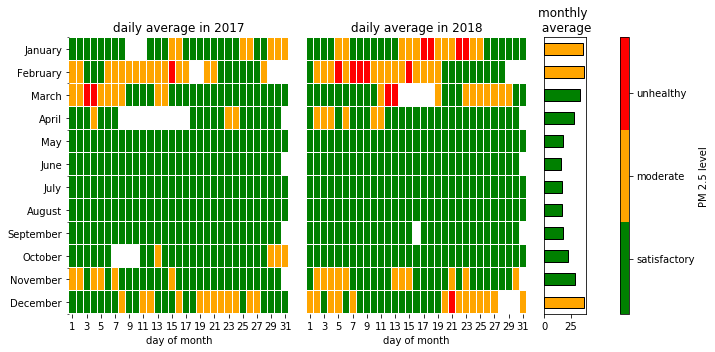

In [436]:
# create a color bar with AQI color system
colors = ['green','orange','red']
levels = [0, 35.4, 55.4]
cmap, norm = mpl.colors.from_levels_and_colors(levels,colors,'max')

fig = plt.figure(figsize= (10,5))
# make a grid space for each subplot
gs = GridSpec(1,10)
# plot the first heatmap for 2017 data
ax1 = fig.add_subplot(gs[0:4])
sns.heatmap(date_month_2017, cmap=cmap, norm=norm, linewidth=0.05,vmax=70, cbar=False, ax=ax1)
ax1.yaxis.label.set_visible(False)
plt.title('daily average in 2017')
plt.xlabel('day of month')

# plot the first heatmap for 2018 data
ax2 = fig.add_subplot(gs[4:8],sharey =ax1)
ax2 = sns.heatmap(date_month_2018, cmap=cmap, norm=norm, linewidth=0.05,vmax=70, cbar=False)
plt.title('daily average in 2018')
plt.xlabel('day of month')
ax2.get_yaxis().set_visible(False)

# plot monthly average as a horizontal side bar, and color coded them
ax3 = fig.add_subplot(gs[8])
monthavg = pm25[['Month','PM2.5avg']].groupby('Month').mean()
monthavg = monthavg.reindex(reversed(month_name))
monthavg['color'] = pd.cut(monthavg['PM2.5avg'],bins = [0, 35.5, 55.5, 150.4], 
                       labels=['green', 'orange','red'],
                      include_lowest=True, right=False).astype(str)
monthavg.plot(y='PM2.5avg', kind='barh',color = monthavg['color'], legend=False, ax=ax3,
             edgecolor='black')
ax3.get_yaxis().set_visible(False)
plt.title('monthly \n average')

# plot the colorbar on the further right
cmap2 = mpl.colors.ListedColormap(colors=['green','orange','red'])
ax4 = fig.add_subplot(gs[9])
ax4.set_aspect(30)
cbar = mpl.colorbar.ColorbarBase(cmap=cmap2, ax=ax4)
cbar.set_ticks([0.2, 0.5, 0.8])
cbar.set_ticklabels(['satisfactory', 'moderate', 'unhealthy'])
cbar.set_label('PM 2.5 level')

plt.tight_layout()

For both 2017 and 2018, the pollution starts around October and last until early March. So tourists should staying in Bangkok in these months. I know what you are thinking. "Hey, those are my holiday! Where else I can go? May suggest Phuket, and Samui Island? The south of Thailand has low AQI all year long. We will see the average pollution for each province later. 

### Day of Week and Hourly average 

What is the suggestion for the local Bangkokians? Is the morning Air or weekend better? What is the best time to go outside? We need to see the day of week data and the hourly average data. 

After playing with the data, I found that too much averaging will obscure the hourly pattern, so I will only show a data for one month. I choose Feb 2018 because it is the month with the worse air.

Note that I played around with different plots and average. You are going to see different versions of the same plots.

#### Day of Week and Hourly average on the same plots

In [87]:
# select Feb 2018 data
pm25_winter = pm25['2018-02']
pm25_winter.head()

,PM2.5,PM2.5avg,Year,Month,DayofMonth,DayofWeek,TimeofDay,level,color
Time,,,,,,,,,
2018-02-01 00:00:00,18.6,24.445833,2018,February,1,Thursday,00:00:00,satisfactory,green
2018-02-01 01:00:00,17.5,23.945833,2018,February,1,Thursday,01:00:00,satisfactory,green
2018-02-01 02:00:00,16.7,23.570833,2018,February,1,Thursday,02:00:00,satisfactory,green
2018-02-01 03:00:00,14.6,23.045833,2018,February,1,Thursday,03:00:00,satisfactory,green
2018-02-01 04:00:00,23.1,23.133333,2018,February,1,Thursday,04:00:00,satisfactory,green


In [88]:
# create new df with day of week as index and hour of day as columns
date_time_map = pd.crosstab(pm25_winter['DayofWeek'],pm25_winter['TimeofDay'], pm25_winter['PM2.5avg'], aggfunc=np.mean)
day_name=pd.date_range('2019-03-04','2019-03-10', freq='D').strftime("%A").tolist()
date_time_map = date_time_map.reindex(day_name)
# use integer number for hours
date_time_map.columns = [int(column[:2]) for column in date_time_map.columns ]
date_time_map.head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
DayofWeek,,,,,,,,,,,,,,,,,,,,,
Monday,44.295833,44.760417,45.240625,45.669792,45.933333,46.202083,46.604167,46.912500,47.011111,47.291667,...,46.645833,47.273958,47.329167,47.222917,52.098611,52.104167,51.986111,51.977778,51.701389,46.572917
Tuesday,46.283333,45.945833,49.776389,44.611458,43.536111,43.402083,42.721875,42.035417,41.353125,40.691667,...,37.426042,36.972917,36.561458,36.332292,36.102083,35.993750,35.938542,35.793750,35.671875,35.623958
Wednesday,35.537500,35.553125,35.892708,38.343056,38.758333,36.902083,37.364583,31.905556,38.758333,39.859375,...,38.837500,43.107292,43.772917,44.350000,36.306944,36.800000,37.175000,45.831250,46.578125,47.288542
Thursday,21.762500,39.286111,45.532292,45.663542,45.966667,54.919444,45.986458,46.118750,46.450000,55.890278,...,34.163889,34.254167,34.101389,45.435417,45.359375,45.482292,45.394792,45.475000,45.586458,45.615625
Friday,45.646875,45.546875,45.461458,45.420833,49.395833,44.873958,44.906250,44.826042,44.868750,44.720833,...,42.467708,42.042708,41.690625,41.488542,41.377083,41.287500,41.294792,41.401042,41.591667,41.806250


day_time_map plot is going to be a heatmap. To help the reader, I am going to have another line plot showing the average for each hour on the bottom of the heatmap. I want these two plots to share the xaxis. Here, I have to turn of the colorbar and plot it as a separate figure. Also, I need to use another colorbar  so the change is more apparent.

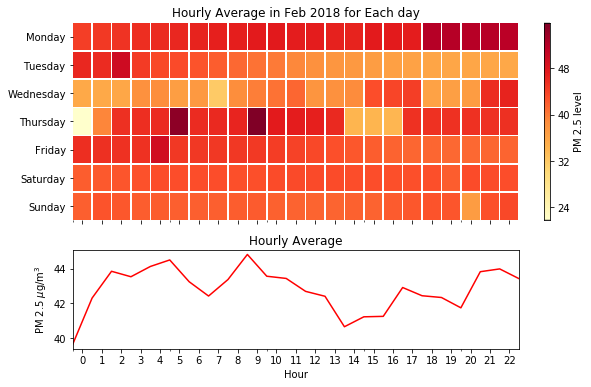

In [111]:
# define grid space
fig = plt.figure(figsize= (9,6))
gs = GridSpec(2, 2, width_ratios=[8, 1], height_ratios=[4, 2])

#plot heatmap
ax1 = fig.add_subplot(gs[0])
ax1 = sns.heatmap(date_time_map, cmap='YlOrRd', linewidth=0.5, cbar=False)
ax1.set_xlabel('Day of Week')
plt.title('Hourly Average in Feb 2018 for Each day')
ax1.yaxis.label.set_visible(False)

#plot colorbar
ax4 = fig.add_subplot(gs[1])
cbar = colorbar(ax1.get_children()[0], ax4)
ax4.set_ylabel('PM 2.5 level')
ax4.set_aspect(30)
plt.subplots_adjust(wspace=0)

#plot hourly average on the bottom
ax2 = fig.add_subplot(gs[2], sharex=ax1)
#plt.bar(date_time_map.mean().index, height=date_time_map.mean().values)
date_time_map.mean().plot(ax=ax2, c='red')
plt.ylabel('PM 2.5 $\mu$g/m$^3$')
plt.xlabel('Hour');
plt.title('Hourly Average');
#plt.tight_layout()

In [150]:
#Select the time range
pm25_winter_2018 = pm25['2018-12':'2019-02']
#genrate table between average time of day and day of week
date_time_map = pd.crosstab(pm25_winter_2018['DayofWeek'],pm25_winter_2018['TimeofDay'], pm25_winter_2018['PM2.5avg'], aggfunc=np.mean)
#create string of Monday to Sunday
day_name=pd.date_range('2019-03-04','2019-03-10', freq='D').strftime("%A").tolist()
#reindex to give index order 
date_time_map = date_time_map.reindex(day_name)
date_time_map.columns = [int(column[:2]) for column in date_time_map.columns.values ]
date_time_map.head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
DayofWeek,,,,,,,,,,,,,,,,,,,,,
Monday,38.397917,38.834470,38.887121,38.911742,38.847727,40.005903,38.664394,38.547727,38.434848,38.375379,...,37.286667,37.136250,38.437500,38.388636,38.361742,38.328788,38.277273,38.220833,38.167803,38.189773
Tuesday,38.191667,39.219167,37.892045,35.173333,36.884259,39.072917,38.819167,38.559167,36.362500,36.226136,...,34.942803,34.640530,34.380682,34.105682,33.895455,33.711742,33.562121,34.463889,35.182500,35.097917
Wednesday,33.178409,32.990152,32.782955,32.587500,32.402273,32.295076,32.239015,32.277273,32.332955,32.510606,...,33.269697,33.304167,33.332197,33.433712,33.573864,33.804545,34.073485,34.335227,34.602652,34.764015
Thursday,34.902273,35.078409,35.266288,35.501136,35.701136,37.002083,34.576667,35.083796,35.942424,35.946970,...,35.779167,35.778030,36.710185,34.672685,34.609722,33.862917,35.605303,33.871250,36.014394,34.518333
Friday,35.315278,35.786111,36.272222,36.763426,36.785417,37.360417,38.298148,38.750926,38.311458,40.642187,...,40.720833,40.765741,40.857407,45.556548,43.598958,42.589583,42.618229,41.492593,41.568981,41.623611


Maybe it is also nice to see the average over different day of week also? I tried adding them as a side plot on the right.

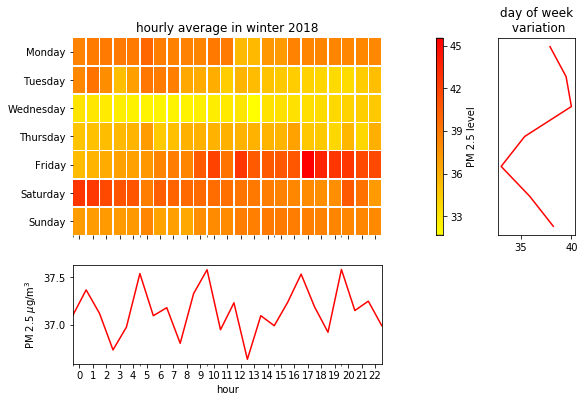

In [151]:
fig = plt.figure(figsize= (9,6))
gs = GridSpec(2, 3, width_ratios=[8, 3, 2], height_ratios=[4, 2])

#plot the date_time_map as heat map
ax1 = fig.add_subplot(gs[0])
ax1 = sns.heatmap(date_time_map, cmap='autumn_r', linewidth=0.5, cbar=False)
plt.title('hourly average in winter 2018')
ax1.yaxis.label.set_visible(False)

# plot color bar on the side
ax4 = fig.add_subplot(gs[1])
cbar = colorbar(ax1.get_children()[0], ax4)
ax4.set_ylabel('PM 2.5 level')
ax4.set_aspect(30)
plt.subplots_adjust(wspace=0)

#plot the average for each day of week on the right
ax3 = fig.add_subplot(gs[2])
ax3.plot(date_time_map.mean(axis=1), day_name,c='red')
ax3.yaxis.set_visible(False)
plt.title('day of week\n variation')

#plot the hourly average on the bottom
ax2 = fig.add_subplot(gs[3], sharex=ax1)
date_time_map.mean().plot(ax=ax2, c='red')
plt.ylabel('PM 2.5 $\mu$g/m$^3$')
plt.xlabel('hour');
#plt.tight_layout()

Morning air is not better. The better time is in in the late afternoon. Weekend is not significantly better compared to the weekdays. This graph is not very useful. Too many graphs.



#### Day of Week and Hourly average on different plots

Instead of putting the day of week and hourly average on the same graph, I will put them on a separate plot. Here, I can also see the trend for each winter season by adding another categorical columns that indicate the month and year.

In [282]:
winterdata = pd.DataFrame(columns=pm25.columns)
# select data during winter 
periods = [('2016-12','2017-02'),('2017-12','2018-02'), ('2018-12','2019-02')]
for start,stop in periods:
    winterdata = pd.concat([winterdata, pm25[start:stop]])
    
# generate a month-year columns
winterdata['month-year'] = winterdata.index.strftime('%b-%Y')
# create a time of day column with integer type
winterdata['TimeofDay'] = [int(time[:2]) for time in winterdata['TimeofDay'].values]

In [283]:
winterdata.head()

,PM2.5,PM2.5avg,Year,Month,DayofMonth,DayofWeek,TimeofDay,level,color,season,is_weekend
2016-12-01 00:00:00,32.4,28.600000,2016,December,1,Thursday,0,satisfactory,green,winter\n2016-2017,weekday
2016-12-01 01:00:00,30.0,28.270833,2016,December,1,Thursday,1,satisfactory,green,winter\n2016-2017,weekday
2016-12-01 02:00:00,31.7,27.837500,2016,December,1,Thursday,2,satisfactory,green,winter\n2016-2017,weekday
2016-12-01 03:00:00,28.6,27.437500,2016,December,1,Thursday,3,satisfactory,green,winter\n2016-2017,weekday
2016-12-01 04:00:00,31.3,27.195833,2016,December,1,Thursday,4,satisfactory,green,winter\n2016-2017,weekday


In [421]:
# resample data by day
dayavg_decFeb = winterdata.resample('d').agg({
    'PM2.5':'mean','Year':'last','Month':'last','DayofWeek':'last',
    'season':'last','is_weekend':'last'
})
# make a level columns
dayavg['level'] = pd.cut(dayavg_decFeb['PM2.5'],bins = [0, 35.5, 55.5, 150.4], 
                       labels=['satisfactory', 'moderate','unhealthy'],
                      include_lowest=True, right=False).astype(str)

dayavg_decFeb['month-year'] = dayavg_decFeb.index.strftime('%b\n%Y')
dayavg_decFeb['Month'] = dayavg_decFeb.index.strftime('%b')
dayavg_decFeb.tail()

,PM2.5,Year,Month,DayofWeek,season,is_weekend,month-year
2019-02-24,26.308333,2019,Feb,Sunday,winter\n2018-2019,weekend,Feb\n2019
2019-02-25,26.690909,2019,Feb,Monday,winter\n2018-2019,weekday,Feb\n2019
2019-02-26,26.856522,2019,Feb,Tuesday,winter\n2018-2019,weekday,Feb\n2019
2019-02-27,27.254167,2019,Feb,Wednesday,winter\n2018-2019,weekday,Feb\n2019
2019-02-28,31.720833,2019,Feb,Thursday,winter\n2018-2019,weekday,Feb\n2019


In [425]:
# create a table with month-year for each columns
day_map = pd.pivot_table(dayavg_decFeb, index='DayofWeek',columns=['month-year'],values='PM2.5',
              aggfunc='mean')
day_name=pd.date_range('2019-03-04','2019-03-10', freq='D').strftime("%A").tolist()

# reorder the data
day_map = day_map.reindex(['Dec\n2016', 'Jan\n2017','Feb\n2017', 'Dec\n2017',
                      'Jan\n2018', 'Feb\n2018',  'Dec\n2018', 'Jan\n2019','Feb\n2019'], axis=1)
day_map = day_map.reindex(day_name)

In [423]:
day_map.columns

Index(['Dec\n2016', 'Dec\n2017', 'Dec\n2018', 'Feb\n2017', 'Feb\n2018',
       'Feb\n2019', 'Jan\n2017', 'Jan\n2018', 'Jan\n2019'],
      dtype='object', name='month-year')

Text(0.5, 1.0, 'daly average in winter')

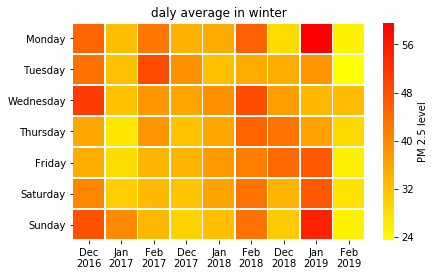

In [427]:
#make a heatmap
fig = plt.figure(figsize= (9,4))
gs = GridSpec(1, 2, width_ratios=[4,1])
ax1 = fig.add_subplot(gs[0])
sns.heatmap(day_map,cmap='autumn_r', linewidth=0.5,ax=ax1,
           cbar_kws={'label': 'PM 2.5 level'})
ax1.yaxis.label.set_visible(False)
ax1.xaxis.label.set_visible(False)
plt.title('daly average in winter')


No pattern. To confirm that there is not trend for day of week, using lineplot.

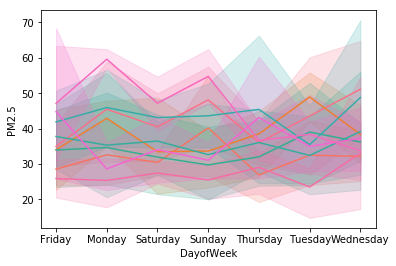

In [442]:
sns.lineplot(data=dayavg_decFeb, x='DayofWeek',y='PM2.5', hue='month-year',
            legend=False)

See if the normalized data would show the paper. I am going to divide each columns by it maximum value.

In [477]:
#normalize
day_map_norm = day_map/day_map.max()

Text(0.5, 1.0, 'daly average in winter')

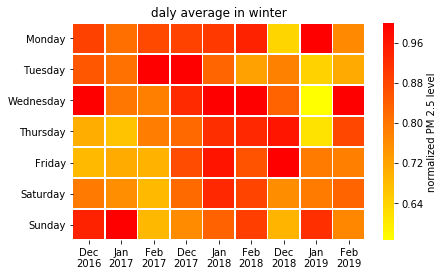

In [478]:
fig = plt.figure(figsize= (9,4))
gs = GridSpec(1, 2, width_ratios=[4,1])
ax1 = fig.add_subplot(gs[0])
sns.heatmap(day_map_norm,cmap='autumn_r', linewidth=0.5,ax=ax1,
           cbar_kws={'label': 'normalized PM 2.5 level'})
ax1.yaxis.label.set_visible(False)
ax1.xaxis.label.set_visible(False)
plt.title('daly average in winter')

Plot the line plot to really make sure there is not trend

In [493]:
day_map_norm_melt = pd.melt(day_map_norm.reset_index(),id_vars='DayofWeek')

In [491]:
day_map_norm_melt.head()

,DayofWeek,month-year,value
0,Monday,Dec\n2016,0.889537
1,Tuesday,Dec\n2016,0.851834
2,Wednesday,Dec\n2016,1.000000
3,Thursday,Dec\n2016,0.704397
4,Friday,Dec\n2016,0.683375


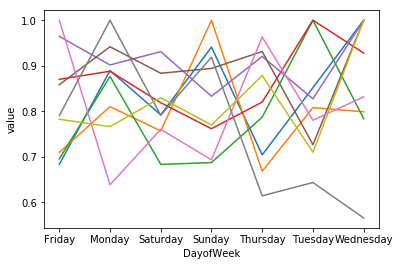

In [494]:
sns.lineplot(data=day_map_norm_melt, x='DayofWeek',y='value', hue='month-year',
            legend=False)

One thing I learn from exploring this data, is too much averaging can make your trend go away. To look at a trend for time of day, I need to look at the raw plot vs time, instead of the average hours value. I will focus on the data in winter.

In [446]:
winterdata.head()

,PM2.5,PM2.5avg,Year,Month,DayofMonth,DayofWeek,TimeofDay,level,color,season,is_weekend,month-year
2016-12-01 00:00:00,32.4,28.600000,2016,December,1,Thursday,0,satisfactory,green,winter\n2016-2017,weekday,Dec-2016
2016-12-01 01:00:00,30.0,28.270833,2016,December,1,Thursday,1,satisfactory,green,winter\n2016-2017,weekday,Dec-2016
2016-12-01 02:00:00,31.7,27.837500,2016,December,1,Thursday,2,satisfactory,green,winter\n2016-2017,weekday,Dec-2016
2016-12-01 03:00:00,28.6,27.437500,2016,December,1,Thursday,3,satisfactory,green,winter\n2016-2017,weekday,Dec-2016
2016-12-01 04:00:00,31.3,27.195833,2016,December,1,Thursday,4,satisfactory,green,winter\n2016-2017,weekday,Dec-2016


In [466]:
# find the hourly average data group by month-year to plot separetely 
hourlyavg_win = winterdata.groupby(['month-year','TimeofDay'],as_index=False).agg({'PM2.5':'mean','DayofWeek':'last'})

monthyear_sorter = ['Dec\n2016', 'Jan\n2017','Feb\n2017', 'Dec\n2017',
                      'Jan\n2018', 'Feb\n2018',  'Dec\n2018', 'Jan\n2019','Feb\n2019']
day_name=pd.date_range('2019-03-04','2019-03-10', freq='D').strftime("%A").tolist()

hourlyavg_win = hourlyavg_win.sort_values(['month-year','DayofWeek'],ascending=[monthyear_sorter,day_name])
hourlyavg_win.head()

,month-year,TimeofDay,PM2.5,DayofWeek
0,Dec-2016,0,50.903226,Saturday
1,Dec-2016,1,49.022581,Saturday
2,Dec-2016,2,50.461290,Saturday
3,Dec-2016,3,47.529032,Saturday
4,Dec-2016,4,45.174194,Saturday


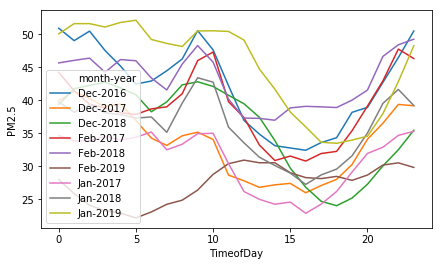

In [464]:
# plot the mean of each month
fig = plt.figure(figsize=(7,4))
sns.lineplot(data=hourlyavg_win, x='TimeofDay',y='PM2.5',hue='month-year')

Text(0, 0.5, 'PM2.5 $\\mu g/m^3$')

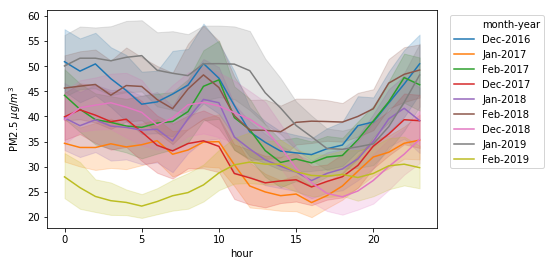

In [474]:
#plot all of the data 
fig = plt.figure(figsize=(7,4))
sns.lineplot(data=winterdata, x='TimeofDay',y='PM2.5',hue='month-year')
plt.legend(bbox_to_anchor=(1.02, 1))
plt.xlabel('hour')
plt.ylabel('PM2.5 $\mu g/m^3$')

I like the last plot the most. It shows that pollution level tend to be low around 15 am. We can also see the peak during the morning rush hour around 8 - 9 am on some month. I will use this for my blog.

# Maps

Looking at the pollution level of the entire countries will tell if the pollution focus on the Bangkok. Is there provinces around Bangkok with worse pollution? If so, the pollution will inevitably flow to Bangkok.What provinces has worse pollution and lowest pollution. 

Here is my procedure.

1. Extract city name, region name and the lattitude and logtitude from all data files, and convert to Mercator system. 
2. Collect PM2.5 data from all provinces in a single DataFrame and save it
3. Get the names of all BKK neighbor province
4. Display the data on a map. I use tile from Stamen.
5. Build interactive plots or gif showing the change over months time 


## 1. Extract city name, region name and the lattitude and logtitude from all data files, and convert to Mercator system. 

I am going to use Bokeh geographical map, which use Mercator coordinate system. 

In [4]:
import re

In [7]:
#Extract geospatial data and city, region information
def geo_info(filename):
    with open(filename,'r') as f:
        data = f.read()
        city = re.search('City: (.+)', data).group(1)
        region = re.search('Region: (.+)', data).group(1)
        pop = re.search('Population: (\w+)', data).group(1)    
        lat = re.search('Latitude: (\d+.\d+)', data).group(1)
        lng = re.search('Longitude: (\d+.\d+)', data).group(1)  
    return [city, region, pop, lat, lng]


In [444]:
region_info = []
for filename in glob('data/*.txt'):
    info = geo_info(filename)
    region_info.append(info)
    

In [445]:
region_df = pd.DataFrame(region_info, columns=['City','Region', 'Population','Latitude','Longitude'])

In [520]:
# function to change to Mercator
#from https://wiki.openstreetmap.org/wiki/Mercator
import math

def merc_x(lon):
  r_major = 6378137.000
  return r_major*math.radians(lon)

def merc_y(lat):
    lat += 0.08
    if lat>89.5:lat=89.5
    if lat<-89.5:lat=-89.5
    r_major=6378137.000
    r_minor=6356752.3142
    temp=r_minor/r_major
    eccent=math.sqrt(1-temp**2)
    phi=math.radians(lat)
    sinphi=math.sin(phi)
    con=eccent*sinphi
    com=eccent/2
    # shift the coordinate a little bit to make them align.
    con=((1.0-con)/(1.0+con))**com
    ts=math.tan((math.pi/2-phi)/2)/con
    y=0-r_major*math.log(ts)
    return y

In [683]:
region_df['x_mer']= region_df.Longitude.apply(merc_x)
region_df['y_mer']= region_df.Latitude.apply(merc_y)

In [649]:
region_df.describe(include='all')

,City,Region,Population,Latitude,Longitude,x_mer,y_mer
count,56,56,5.600000e+01,56.000000,56.000000,5.600000e+01,5.600000e+01
unique,56,41,NaN,NaN,NaN,NaN,NaN
top,Pak Kret,Nonthaburi,NaN,NaN,NaN,NaN,NaN
freq,1,3,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,1.956620e+05,13.554377,100.738621,1.121417e+07,1.572554e+06
std,NaN,NaN,6.713606e+05,3.231692,1.311508,1.459965e+05,3.675895e+05
min,NaN,NaN,5.000000e+04,6.540000,98.398100,1.095363e+07,7.804353e+05
25%,NaN,NaN,5.834075e+04,12.677275,99.953025,1.112672e+07,1.470258e+06
50%,NaN,NaN,8.311300e+04,13.840150,100.524200,1.119030e+07,1.602694e+06
75%,NaN,NaN,1.237000e+05,15.731150,101.027775,1.124636e+07,1.819571e+06


In [453]:
region_df.query('Region == "Nonthaburi"')

,City,Region,Population,Latitude,Longitude
1,Bang Kruai,Nonthaburi,78305,13.805,100.4728
25,Mueang Nonthaburi,Nonthaburi,291555,13.8607,100.5148
31,Pak Kret,Nonthaburi,182926,13.913,100.4988


In [78]:
region_df['Region'] = region_df['Region'].str.replace('TH.S','Chonburi')
region_df['Region'] = region_df['Region'].str.replace('Changwat','')

In [79]:
region_df.to_csv('data/region_info.csv', index=False)

In [10]:
region_df = pd.read_csv('data/region_info.csv')

## 2. Collect PM 2.5 data from all provinces

Put them in in a single DataFrame and save it

In [8]:
def read_pm(filename):
    pm25 = pd.read_csv(filename, sep='\t', header=None, skiprows=10)
    #assemble datetime column 
    pm25['Time'] = pd.to_datetime({'year': pm25[0], 'month': pm25[1], 'day':pm25[2],'hour': pm25[3]})
    #convert time zone
    pm25['Time'] = pm25['Time'].dt.tz_localize('UTC').dt.tz_convert('Asia/Bangkok')
    pm25['Time'] = pm25['Time'].dt.tz_localize(None)
    pm25=pm25.drop([0,1,2,3,5,6],axis=1)
    pm25.columns = ['PM2.5', 'Time']
    
    city = geo_info(filename)[0]
    pm25['city'] = city
    
    return pm25

In [9]:
pm25_all = pd.DataFrame()
for filename in glob('data/pm25/*.txt'):
    pm25_region = read_pm(filename)
    pm25_all = pm25_all.append(pm25_region,ignore_index=True)


In [10]:
pm25_all.to_csv('data/pm25_all.csv', index=False)

In [20]:
pm25_all = pd.read_csv('data/pm25_all.csv')
pm25_all['Time'] = pd.to_datetime(pm25_all['Time'])

In [23]:
pm25_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1249843 entries, 0 to 1249842
Data columns (total 3 columns):
PM2.5    1249843 non-null float64
Time     1249843 non-null datetime64[ns]
city     1249843 non-null object
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 28.6+ MB


## 3. Get the names of all Bangkok neighbor provinces

In [383]:
# Obtain all province in BKK neighbors
bkk_nei = ['Bangkok']
with open('data/Bangkok.neighbors.json') as json_file:  
    data = json.load(json_file)
    for vec in data:
        bkk_nei.append(vec[1])

#remove province not in the proximity of BKK 
bkk_nei = bkk_nei[:8]

In [384]:
bkk_nei

['Bangkok',
 'Nonthaburi',
 'Samut_Prakan',
 'Samut_Sakhon',
 'Pathum_Thani',
 'Nakhon_Pathom',
 'Phra_Nakhon_Si_Ayutthaya',
 'Ratchaburi']

In [4]:
# load the region info and pm25 records
region_df = pd.read_csv('data/region_info.csv')

pm25_all = pd.read_csv('data/pm25_all.csv')
pm25_all['Time'] = pd.to_datetime(pm25_all['Time'])
pm25_all.set_index('Time',inplace=True)

## 4. Display the data on a map. 

I use tile from Stamen and Bokeh plot, the data is group by month.
First, try to plot the data for a single month, Jan 2019.

In [40]:
# select data for Jan 2019 for all regions
pm25_all_jan19 = pm25_all['2019-01']

In [41]:
# take the average 
reg_monthavg = pm25_all_jan19.groupby('city', as_index=False).mean()
reg_monthavg = reg_monthavg.merge(region_df, left_on ='city', right_on='City').drop('city',axis=1)

In [42]:
# create level based on the PM2.5 data
reg_monthavg['level'] = pd.cut(reg_monthavg['PM2.5'],bins = [0, 35.5, 55.5, 150.4], 
                       labels=['satisfactory', 'moderate','unhealthy'],
                      include_lowest=True, right=False)
# try if the bubble plot work (it didn't)
reg_monthavg['size'] = [25 if x=='Bangkok' else 20 for x in reg_monthavg.City]

In [38]:
reg_monthavg.head(8)

,PM2.5,City,Region,Population,Latitude,Longitude,x_mer,y_mer,level,size
0,33.498706,Ban Lam Luk Ka,Pathum Thani,60700,13.9774,100.7778,1.121853e+07,1.570430e+06,satisfactory,20
1,11.950485,Ban Mai,Songkhla,86899,7.2041,100.5451,1.119263e+07,8.076416e+05,satisfactory,20
2,39.884466,Ban Pong,Ratchaburi,57559,13.8163,99.8774,1.111830e+07,1.552066e+06,moderate,20
3,16.423948,Ban Talat Yai,Phuket,52192,7.8848,98.4001,1.095385e+07,8.835903e+05,satisfactory,20
4,37.358900,Bang Kruai,Nonthaburi,78305,13.8050,100.4728,1.118458e+07,1.550779e+06,moderate,20
5,35.795146,Bangkok,Bangkok,5104476,13.7540,100.5014,1.118776e+07,1.544968e+06,moderate,25
6,30.250647,Chaiyaphum,Chaiyaphum,58350,15.8105,102.0288,1.135779e+07,1.780353e+06,satisfactory,20
7,23.726699,Chanthaburi,Chanthaburi,99819,12.6096,102.1045,1.136622e+07,1.414911e+06,satisfactory,20


In [3]:
from bokeh.io import output_file, output_notebook, show, reset_output,export_png
from bokeh.models import (
  GMapPlot, GMapOptions, ColumnDataSource, Circle, LogColorMapper, BasicTicker, ColorBar,
    DataRange1d, PanTool, WheelZoomTool, BoxSelectTool, CategoricalColorMapper, Slider, DateRangeSlider
)
from bokeh.models.mappers import ColorMapper, LinearColorMapper
from bokeh.palettes import Viridis5
from bokeh.plotting import figure, show, output_file
from bokeh.tile_providers import STAMEN_TERRAIN,CARTODBPOSITRON_RETINA
from bokeh.layouts import widgetbox


In [5]:
output_notebook()

Loading BokehJS ...

In [32]:
# center the plot on bangkok, using the coordinate of BKK
[[bkk_x, bkk_y]]= region_df.query('City == "Bangkok"')[['x_mer','y_mer']].values
stepx = 1E5
stepy = stepx

print(bkk_x,bkk_y,stepx,stepy)

11187764.672011103 1544967.9205643306 100000.0 100000.0


In [45]:
# range bounds supplied in web mercator coordinates
p = figure(x_range=(bkk_x-stepx,bkk_x+1.5*stepx), y_range=(bkk_y-stepy, bkk_y+stepy),
           x_axis_type="mercator", y_axis_type="mercator",
          title = 'PM 2.5 Pollution January 2019')
p.add_tile(STAMEN_TERRAIN)

source = ColumnDataSource(reg_monthavg)
color_mapper = CategoricalColorMapper(factors=['satisfactory', 'moderate', 'unhealthy'],
                                      palette=['green', 'orange', 'red'])

p.circle(source=source, x='x_mer',y='y_mer', size='size', alpha=0.7,
        color=dict(field='level',transform=color_mapper), legend='level')


show(p)

In [51]:
export_png(p,filename='bkk_jan2019.png')

'C:\\Users\\Benny\\Documents\\Fern\\BKK-AQI\\bkk_jan2019.png'

## 5. Building interactive maps 
- Show monthly average air pollution for the entire country
- Plot the monthly average on the side of the map.
- Plot the yearly average of each province, rank them to find the the provinces with has the highest and lowest air pollutions?
- Turn the maps into gif

In [20]:
from bokeh.io import output_file, output_notebook, show,curdoc, reset_output,export_png
from bokeh.models import (
  GMapPlot, GMapOptions, ColumnDataSource, Circle, LogColorMapper, BasicTicker, ColorBar,
    DataRange1d, PanTool, WheelZoomTool, BoxSelectTool, CategoricalColorMapper, Slider, DateRangeSlider,
    DateSlider, SingleIntervalTicker, LinearAxis,Legend, LegendItem
)
from bokeh.models.mappers import ColorMapper, LinearColorMapper
from bokeh.palettes import Viridis5
from bokeh.plotting import figure, show, output_file
from bokeh.tile_providers import STAMEN_TERRAIN,CARTODBPOSITRON_RETINA
from bokeh.layouts import widgetbox,row, column, gridplot

In [16]:
region_df = pd.read_csv('data/region_info.csv',sep=';')
pm25_all = pd.read_csv('data/pm25_all.csv').dropna()
pm25_all['Time'] = pd.to_datetime(pm25_all['Time'])
pm25_all.head()

,PM2.5,Time,city
0,62.9,2016-03-03 15:00:00,Bangkok
1,62.9,2016-03-03 16:00:00,Bangkok
2,55.5,2016-03-03 17:00:00,Bangkok
3,55.5,2016-03-03 18:00:00,Bangkok
4,47.9,2016-03-03 19:00:00,Bangkok


In [19]:
pm25_all.tail()

,PM2.5,Time,city,month,year
1266694,19.1,2019-03-20 16:00:00,Yala,2019-03,2019
1266695,15.8,2019-03-20 17:00:00,Yala,2019-03,2019
1266696,14.9,2019-03-20 18:00:00,Yala,2019-03,2019
1266697,17.7,2019-03-20 19:00:00,Yala,2019-03,2019
1266698,16.8,2019-03-20 20:00:00,Yala,2019-03,2019


In [17]:
pm25_all['month'] = pm25_all['Time'].dt.to_period('M')
pm25_all['year'] = pm25_all['Time'].dt.to_period('Y')
pm25_all.head()

,PM2.5,Time,city,month,year
0,62.9,2016-03-03 15:00:00,Bangkok,2016-03,2016
1,62.9,2016-03-03 16:00:00,Bangkok,2016-03,2016
2,55.5,2016-03-03 17:00:00,Bangkok,2016-03,2016
3,55.5,2016-03-03 18:00:00,Bangkok,2016-03,2016
4,47.9,2016-03-03 19:00:00,Bangkok,2016-03,2016


In [18]:
# find the monthly average 
monthly_all = pm25_all.groupby(['month','city'],as_index=False).mean()
#monthly_all['month'] = monthly_all['month'].values.astype('datetime64[M]')
monthly_all['city'] = monthly_all['city'].astype('category')
monthly_all = monthly_all.merge(region_df, left_on=['city'], right_on='City')
# group by the level 
monthly_all['level'] = pd.cut(monthly_all['PM2.5'],bins = [0, 35.5, 55.5, 150.4], 
                       labels=['satisfactory', 'moderate','unhealthy'],
                      include_lowest=True, right=False)
monthly_all = monthly_all.drop(['city','City','Population','Latitude','Longitude'],axis=1)
#sort by the lattitue
monthly_all.sort_values('y_mer',ascending=False,inplace=True)
monthly_all.tail()

,month,PM2.5,Region,x_mer,y_mer,dis2BKK,level
1841,2019-02,17.980260,Yala,1.127458e+07,733657.663071,815942.223042,satisfactory
1840,2019-01,18.564031,Yala,1.127458e+07,733657.663071,815942.223042,satisfactory
1839,2018-12,14.292233,Yala,1.127458e+07,733657.663071,815942.223042,satisfactory
1838,2018-11,16.203863,Yala,1.127458e+07,733657.663071,815942.223042,satisfactory
1823,2017-08,16.498505,Yala,1.127458e+07,733657.663071,815942.223042,satisfactory


In [13]:
# build a map center on Bangkok
month_min = monthly_all['month'].min().strftime('%Y-%m')
month_max = monthly_all['month'].max().strftime('%Y-%m')
[[bkk_x, bkk_y]]= region_df.query('City == "Bangkok"')[['x_mer','y_mer']].values
stepx = 3E5
stepy = 3*stepx

In [21]:
reset_output()

In [22]:
output_notebook()

Loading BokehJS ...

In [23]:
# build the interactive map
def plot_monthly(doc):
    
# create figure 
    p = figure(x_range=(bkk_x-0.3*stepx, bkk_x+stepx), y_range=(bkk_y-stepy, bkk_y+stepy),
               x_axis_type="mercator", y_axis_type="mercator",
               title='PM 2.5 Pollution', plot_width=450, plot_height=600)
    # add map
    p.add_tile(STAMEN_TERRAIN)

    source = ColumnDataSource(monthly_all[monthly_all['month'] == '2019-03'])
    # make colorbar
    color_mapper = CategoricalColorMapper(factors=['satisfactory', 'moderate', 'unhealthy'],
                                          palette=['green', 'orange', 'red'])

    #plot the pollution reading
    r = p.circle(source=source, x='x_mer', y='y_mer', size=15, alpha=0.7,
                 color=dict(field='level', transform=color_mapper))
    
    # create legend
    legend = Legend(items=[LegendItem(label=dict(field='level'), renderers=[r])], location="bottom_right")

    
    p.add_layout(legend)

    #put monthly average bar graph on the side
    p2 = figure(y_range=monthly_all['Region'].iloc[::-1].unique(), x_range=(0, 70),
                plot_width=200, plot_height=600, toolbar_location=None)

    p2.xaxis.major_label_orientation = math.pi/2
    p2.xaxis.ticker = [0, 20, 40, 60]

    p2.hbar(y='Region', right='PM2.5', height=0.5, source=source,
            color=dict(field='level', transform=color_mapper))

    # add slider bar for selecting month
    def callback(attr, old, new):
        data = monthly_all[monthly_all['month'] == new]
        source.data = ColumnDataSource(data=data).data

    slider = DateSlider(title='Month of Year', start=month_min, end=month_max, step=1,
                        value=month_min, format='%B %Y')
    slider.on_change('value', callback)

    layout = column(widgetbox(slider), row(p2, p))
    doc.add_root(layout)

In [27]:
show(plot_monthly)

In [51]:
def show_monthly(monthly_all, month):
    '''function to create pollution map for each month and
    save it as png file
    '''

    # create figure
    p = figure(x_range=(bkk_x-0.3*stepx, bkk_x+stepx), y_range=(bkk_y-stepy, bkk_y+stepy),
               x_axis_type="mercator", y_axis_type="mercator",
               title='PM 2.5 Pollution in '+month.strftime('%B %Y'), plot_width=450, plot_height=600)
    # map
    p.add_tile(STAMEN_TERRAIN)

    source = ColumnDataSource(monthly_all[monthly_all['month'] == month])
    color_mapper = CategoricalColorMapper(factors=['satisfactory', 'moderate', 'unhealthy'],
                                          palette=['green', 'orange', 'red'])

    #add the pollution data colored by level
    r = p.circle(source=source, x='x_mer', y='y_mer', size=15, alpha=0.7,
                 color=dict(field='level', transform=color_mapper))
    
    legend = Legend(items=[LegendItem(label=dict(field='level'), renderers=[r])], location="bottom_right")

    
    p.add_layout(legend)

    # add monthly average as a side bar, color coded by level
    p2 = figure(y_range=monthly_all['Region'].iloc[::-1].unique(), x_range=(0, 70),
                plot_width=200, plot_height=600, toolbar_location=None)

    p2.xaxis.major_label_orientation = math.pi/2
    p2.xaxis.ticker = [0, 20, 40, 60]

    p2.hbar(y='Region', right='PM2.5', height=0.5, source=source,
            color=dict(field='level', transform=color_mapper))

    layout = row(p2, p)
    month = month.strftime('%Y-%m')
    # save the figure for each month for building gif
    export_png(layout,filename='monthly_map/'+month+'monthly_map.png')

In [52]:
# call the function to create the map and save it
for month in monthly_all['month'].unique():
    show_monthly(monthly_all, month)

In [6]:
from glob import glob
import imageio

In [8]:
# load all the pollution map fire 
filenames = glob('monthly_map/*.png')

In [9]:
# create a gif showing pollution level for each month
images = []
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('monthly_map/monthly_map.gif', images, duration=0.5)

#### Finding yearly average for each province

Show the data for each province in 2017 and 2018 as bar plot, rank by the pollution level.

In [14]:
# create yearly average group by city
yearly_all = pm25_all.groupby(['year','city'], as_index=False).max()
yearly_all['year'] = yearly_all['year'].values.astype(str)
yearly_all['city'] = yearly_all['city'].astype('category')
yearly_all = yearly_all.merge(region_df,left_on='city',right_on='City')

# separate by level
yearly_all['level'] = pd.cut(yearly_all['PM2.5'],bins = [0, 35.5, 55.5, 150.4], 
                       labels=['satisfactory', 'moderate','unhealthy'],
                      include_lowest=True, right=False)
yearly_all = yearly_all.drop(['city','Population','Latitude','Longitude','City'],axis=1)

# drop the value in 2016 and 2019 due to incomplete data 
yearly_all = yearly_all.drop(yearly_all.loc[yearly_all['year'].isin(['2016','2019'])].index)
yearly_all.sort_values('PM2.5',ascending=False,inplace=True)
yearly_all.reset_index(inplace=True)
yearly_all.tail()

,index,year,PM2.5,Time,month,Region,x_mer,y_mer,level
106,45,2017,59.2,2017-12-31 23:00:00,2017-12,Chumphon,1.104063e+07,1.176187e+06,unhealthy
107,6,2018,59.2,2018-12-31 23:00:00,2018-12,Songkhla,1.119263e+07,8.076416e+05,unhealthy
108,118,2018,58.3,2018-12-31 23:00:00,2018-12,Nakhon Si Thammarat,1.112824e+07,9.448815e+05,unhealthy
109,205,2017,52.8,2017-12-31 23:00:00,2017-12,Trang,1.108869e+07,8.469228e+05,moderate
110,206,2018,44.8,2018-12-31 23:00:00,2018-12,Trang,1.108869e+07,8.469228e+05,moderate


In [15]:
monthly_all['year'] = monthly_all['month'].dt.strftime('%Y')
yearly_all = monthly_all.groupby(['year','Region'], as_index=False).max()
# sort data by pollution level
yearly_all.sort_values('PM2.5',ascending=False,inplace=True)

# drop the value in 2016 and 2019 due to incomplete data 
yearly_all = yearly_all.drop(yearly_all.loc[yearly_all['year'].isin(['2016','2019'])].index)

yearly_all.tail()

,year,Region,PM2.5,month,x_mer,y_mer
59,2017,Nakhon Si Thammarat,22.758319,2017-12,1.112824e+07,944881.495734
77,2017,Trang,22.458169,2017-12,1.108869e+07,846922.840036
118,2018,Trang,21.950633,2018-12,1.108869e+07,846922.840036
66,2017,Phuket,21.274390,2017-12,1.095385e+07,884237.988691
115,2018,Songkhla,21.247627,2018-12,1.119820e+07,807641.616273


In [16]:
# this province has incomplete data 
yearly_all = yearly_all[yearly_all['Region']!=' Ubon Ratchathani']

C:\Users\Benny\Anaconda3\envs\fastai\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


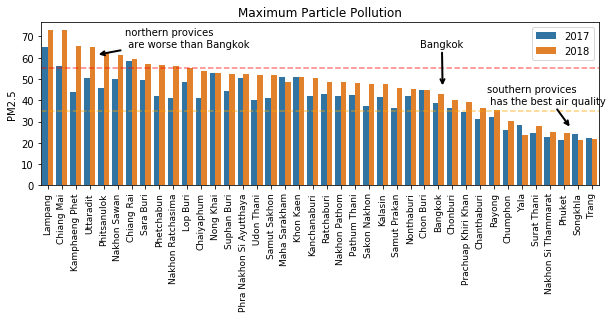

In [20]:
f = plt.figure(figs ize=(10,3))

# create the pollution level line for comparision
plt.axhline(55, color='red', alpha=0.5, linestyle='--')
plt.axhline(35, color='orange', alpha=0.5,linestyle='--')

g = sns.barplot(x="Region", y="PM2.5", hue='year', data=yearly_all)
plt.legend(loc= 'upper right')
plt.xticks(rotation=90, fontsize=9)
ax1 = plt.axes()
ax1.xaxis.label.set_visible(False)

# addnotation 
plt.annotate('southern provices\n has the best air quality',xycoords='axes fraction',
              textcoords='axes fraction',
             xy = (0.95,0.35), xytext=(0.8,0.5), arrowprops=dict(arrowstyle='->', lw = 2))

plt.annotate('northern provices\n are worse than Bangkok',xycoords='axes fraction',
              textcoords='axes fraction',
             xy = (0.1,0.8), xytext=(0.15,0.85), arrowprops=dict(arrowstyle='->', lw = 2))

plt.annotate('Bangkok',xycoords='axes fraction',xy = (0.72,0.6),
            textcoords='axes fraction', xytext=(0.68,0.85),
            arrowprops=dict(arrowstyle='->', lw = 2))
plt.title('Maximum Particle Pollution')
plt.show(g)

In [309]:
p2 = figure(y_range=monthly_all['City'].unique(), 
                plot_width=200, plot_height=600,toolbar_location=None)
source = ColumnDataSource(monthly_all[monthly_all['month'] == '2019-03'])
    
p2.hbar(y='City',right= 'PM2.5', height=0.5, source=source)


show(p2)